This notebook replicates the computation and plot from `indices_nino_1.ncl`

In [1]:
import xarray as xr

In [38]:
import matplotlib.pyplot as plt

In [10]:
#---------------------------------------------------------------------------
#                         User input
#---------------------------------------------------------------------------

latS  = -5.0
latN  =  5.0
lonL  = 190.0
lonR  = 240.0

nrun  = 5             # length of running average

yrStrt= 1870  
yrLast= 2012      

clStrt= 1950          # climatology start    
clLast= 1979          #             last

txtName = "NINO_34"

pltType = "png"       # send graphics to PNG file
pltDir  = "./"        # dir to which plots are sent
pltName = "indices_nino"
#pltName = txtName+"."+yrStrt+"-"+yrLast
# CHANGE: can't concatenate str and int, but we can just do this all in f-string:
pltTitle= f"{txtName}: {yrStrt}-{yrLast}: Base {clStrt}-{clLast}"

ASCII      = True         # create ASCII
ascDir     = "./"

netCDF     = True         # create netCDF
cdfDir     = "./"


In [9]:
#-------------------- End User Input ---------------------------------------

# NOTE: This code makes YYYYMM ints
#ymStrt = yrStrt*100 +  1            
#ymLast = yrLast*100 + 12
# NOTE: These lines overwrite the user input to make it YYYYMM
#clStrt = clStrt*100 +  1              # redefine
#clLast = clLast*100 + 12
#diri   = "./"  # where the input file resides
# NOTE: This seems like a bad idea... and I think we can avoid YYYYMM overall.



In [3]:
# Don't know where the original is, but we can borrow the same file 
# "https://web.lcrc.anl.gov/public/e3sm/diagnostics/observations/Ocean/SST/MODEL.SST.HAD187001-198110.OI198111-201203.nc"
ds = xr.open_dataset("/Users/brianpm/Downloads/MODEL.SST.HAD187001-198110.OI198111-201203.nc")

In [14]:

#*********************************
# The index code below assumes that each year has 12 months 
# 'mon_fullyear_n' (available c6.1.0) may expand to fill that condition
#*********************************
# X      = mon_fullyear( in->SST(:,{latS:latN},{lonL:lonR}), 0)   # all times on file
x = ds['SST'].sel(lat=slice(latS, latN), lon=slice(lonL, lonR))
# NCL -> py : what does mon_fullyear do?
# Not documented on NCL site (?!?)
# tracked source to [https://www.ncl.ucar.edu/Applications/Scripts/mon_fullyear.ncl]
# It pads a year out to "full" years. We actually won't need it.


#YYYYMM = cd_calendar(X&time, -1)      # ALL dates assciated with X
#tStrt  = ind(YYYYMM.eq.ymStrt)        # indices of selected times
#tLast  = ind(YYYYMM.eq.ymLast)
#delete(YYYYMM)

#x      = X(tStrt:tLast,:,:)           # subset to desired time interval
#yyyymm = cd_calendar(x&time, -1) 
#dimx   = dimsizes(x)
#ntim   = dimx(0)

#delete(X)                             # no longer needed


# NOTE: we may have ragged years, report the first and last:
print(f"First time in record is {x.time[0].values} and last time in record is {x.time[-1].values}")

First time in record is 1870-01-16T12:00:00.000000000 and last time in record is 2012-03-16T12:00:00.000000000


In [27]:
# Just for fun, let's define a version of printVarSummary:
def printVarSummary(da):
    n = da.name
    if hasattr(da, 'units'):
        u = da.units
    else:
        u = None
    if hasattr(da, 'long_name'):
        lng = da.long_name
    else:
        lng = "NO LONG NAME"
    c = []
    for i in da.dims:
        if i in da.coords:
            c.append(f"\t dim: {i} with coordinate of shape {da.coords[i].shape}")
        else:
            c.append(f"\t dim: {i} with no coordinate variable")
    mn = da.min().values.item()
    mx = da.max().values.item()
    print(f"{n} ({u})\n  {lng}\n  minimum: {mn}\n  maximum: {mx}")
    for i in c:
        print(i)



In [28]:
printVarSummary(x)

SST (degC)
  Sea Surface Temperature
  minimum: 20.400646209716797
  maximum: 30.750333786010742
	 dim: time with coordinate of shape (1707,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)


In [29]:

#*********************************
# time indices for base climatology 
#*********************************

#  iClmStrt = ind(yyyymm.eq.clStrt)     
#  iClmLast = ind(yyyymm.eq.clLast)    
 #print(yyyymm(iClmStrt:iClmLast))

#*********************************
# Climatology and anomalies from base climatology   
#*********************************

# NCL -> py
# clmMonTLL
# Calculates long term monthly means (monthly climatology) from monthly data: (time,lat,lon) version
#   xClm     = clmMonTLL(x(iClmStrt:iClmLast,:,:))
xClm = x.groupby('time.month').mean(dim="time")
printVarSummary(xClm)
xAnom = x.groupby('time.month') - xClm 
xAnom.attrs['long_name'] = "SST Anomalies"
printVarSummary(xAnom)


SST (None)
  NO LONG NAME
  minimum: 23.489288330078125
  maximum: 29.20751190185547
	 dim: month with coordinate of shape (12,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
SST (None)
  SST Anomalies
  minimum: -3.8082504272460938
  maximum: 5.607343673706055
	 dim: time with coordinate of shape (1707,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)


In [31]:

#*********************************
# Unweighted areal averages & anomalies (time series)
# Small latitudinal extent so no need to weight    
#*********************************
# NOTE: if you don't need to do a weighted average
#       it is probably better to not call a specialized function.

#  x_avg     = wgt_areaave_Wrap(x    , 1.0, 1.0, 1)
#  x_avg@long_name = "areal avg"

#  xAnom_avg = wgt_areaave_Wrap(xAnom, 1.0, 1.0, 1)
#  xAnom_avg@long_name = "areal avg anomalies"

x_avg = x.mean(dim=("lat", "lon"))
xAnom_avg = xAnom.mean(dim=("lat", "lon"))

printVarSummary(xAnom_avg)

#*********************************
# Compute standardized anomalies; use clm period    
#*********************************
xAnom_std = xAnom_avg / xAnom_avg.sel(time=slice(f"{clStrt}-01-01",f"{clLast}-12-31")).std()
xAnom_std.attrs["long_name"] = "areal avg standardized anomalies"
printVarSummary(xAnom_std)


SST (None)
  NO LONG NAME
  minimum: -2.4200010299682617
  maximum: 2.8579728603363037
	 dim: time with coordinate of shape (1707,)
SST (None)
  areal avg standardized anomalies
  minimum: -3.2441561309786064
  maximum: 3.831283566500004
	 dim: time with coordinate of shape (1707,)


In [33]:
#*********************************
# Perform an unweighted nrun-month running average on the index
# 2 months lost at start & end if endopt=0  ... reflective if endopt=1
#*********************************
xAnom_std_smth = xAnom_std.rolling(time=nrun).mean()
printVarSummary(xAnom_std_smth)
# print(f'yyyymm+"   "+{x_avg}+"   "+{xAnom_avg}+"   "+{xAnom_std}')

None (None)
  NO LONG NAME
  minimum: -2.554617956158816
  maximum: 3.5717877677509438
	 dim: time with coordinate of shape (1707,)


<xarray.DataArray 'time' (time: 1707)>
array(['1870-01-16T12:00:00.000000000', '1870-02-15T00:00:00.000000000',
       '1870-03-16T12:00:00.000000000', ..., '2012-01-16T12:00:00.000000000',
       '2012-02-15T00:00:00.000000000', '2012-03-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T12:00:00 ... 2012-03-16T12:00:00
Attributes:
    information:  middle of month

[(<xarray.DataArray ()>
  array(1870.083333), <xarray.DataArray ()>
  array(2012.25)), (<xarray.DataArray ()>
  array(1870.083333), <xarray.DataArray ()>
  array(2012.25))]

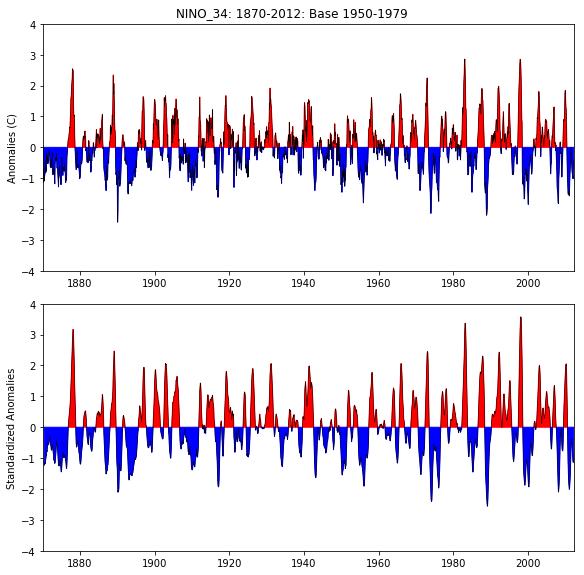

In [48]:
#*********************************
# plot
#*********************************
yrfrac = xAnom_avg['time.year'] + (xAnom_avg['time.month']/12)

fig, ax = plt.subplots(figsize=(8,8), nrows=2, constrained_layout=True)
#wks = gsn_open_wks(pltType, pltDir+pltName)     
#plot = new(2, graphic )

res                       = True       

res_gsnYRefLine           = 0.0            # create a reference line 
res_gsnAboveYRefLineColor = "red"              # above ref line fill red
res_gsnBelowYRefLineColor = "blue"            # below ref line fill blue

res_trYMinF               = -4.0           # min value on y-axis
res_trYMaxF               =  4.0           # max value on y-axis


resP_gsnPanelMainString   = pltTitle                            

res_tiYAxisString = "Anomalies (C)"    # y-axis label      
ax[0].plot(yrfrac, xAnom_avg, 'k', linewidth=0.5)
ax[0].fill_between(yrfrac, xAnom_avg, where=xAnom_avg>=0, interpolate=True, color='red')
ax[0].fill_between(yrfrac, xAnom_avg, where=xAnom_avg<0, interpolate=True, color='blue')
ax[0].set_ylabel(res_tiYAxisString)
ax[0].set_ylim([res_trYMinF, res_trYMaxF])

res_tiYAxisString = "Standardized Anomalies"    # y-axis label      
ax[1].plot(yrfrac, xAnom_std_smth, 'k', linewidth=0.5)
ax[1].fill_between(yrfrac, xAnom_std_smth, where=xAnom_std_smth>=0, interpolate=True, color='red')
ax[1].fill_between(yrfrac, xAnom_std_smth, where=xAnom_std_smth<0, interpolate=True, color='blue')
ax[1].set_ylabel(res_tiYAxisString)
ax[1].set_ylim([res_trYMinF, res_trYMaxF])

fig.suptitle(resP_gsnPanelMainString)

# also set the x extent to be at the time boundaries
[aa.set_xlim([yrfrac.min(), yrfrac.max()]) for aa in ax]



In [ ]:

# The rest of the NCL example is how to save the values to files.
# We will skip that for now.
#
#   if (netCDF) then
# #*************************************************************************
# # Create netCDF: avg, anomalies, standardizes index
# #*************************************************************************
#       yyyymm!0 = "time"
#       yyyymm&time = x_avg&time

#       cdfName = txtName+"."+yrStrt+"-"+yrLast+".nc"
#       cdfPath = cdfDir+cdfName

#       system("/bin/rm -f "+cdfPath)         ; remove any pre-existing file
#       ncdf     = addfile(cdfPath ,"c")      ; open output netCDF file

#     ; make time and UNLIMITED dimension     ; recommended  for most applications
#       filedimdef(ncdf,"time",-1,True)

#       ncdf->yyyymm      =  yyyymm
#       ncdf->SST_REGION  =  x_avg
#       ncdf->SST_ANOM    =  xAnom_avg
#       ncdf->NINO34      =  xAnom_std
#   end if

#   if (ASCII) then
# ;*************************************************************************
# ; Create 3 ASCII (text) files: avg, anomalies, standardizes index
# ;*************************************************************************
#       nmos    = 12
#       year    = ispan(yrStrt,yrLast,1)
#       nyrs    = dimsizes(year)
#       text    = new ( nyrs, "string")

#       x_avg@_FillValue     = 9999.0   ; change for ascii
#       xAnom_avg@_FillValue = 9999.0
#       xAnom_std@_FillValue = 9999.0

# ; text file with area averages

#       ascName = txtName+"."+yrStrt+"-"+yrLast+".AVG.txt"
#       ascPath = ascDir+ascName
#       system("/bin/rm -f "+ascPath)    ; remove any pre-existing file

#       work    = onedtond(x_avg, (/nyrs,nmos/)) 
#       do nyr=0,nyrs-1
#          text(nyr) = sprinti("%0.4i", year(nyr))
#         do nmo=0,nmos-1
#            text(nyr) = text(nyr) + sprintf("%8.2f", work(nyr, nmo))
#         end do
#       end do
#       asciiwrite(ascPath, text) 

#       delete(work)

# ; text file with anomaly averages

#       ascName = txtName+"."+yrStrt+"-"+yrLast+".ANOM.txt"
#       ascPath = ascDir+ascName
#       system("/bin/rm -f "+ascPath)    ; remove any pre-existing file

#       work    = onedtond(xAnom_avg, (/nyrs,nmos/)) 
#       do nyr=0,nyrs-1
#          text(nyr) = sprinti("%0.4i", year(nyr))
#         do nmo=0,nmos-1
#            text(nyr) = text(nyr) + sprintf("%8.2f", work(nyr, nmo))
#         end do
#       end do
#       asciiwrite(ascPath, text) 

#       delete(work)

# ; text file with index values      

#       ascName = txtName+"."+yrStrt+"-"+yrLast+".INDEX.txt"
#       ascPath = ascDir+ascName
#       system("/bin/rm -f "+ascPath)    ; remove any pre-existing file

#       work    = onedtond(xAnom_std, (/nyrs,nmos/)) 
#       do nyr=0,nyrs-1
#          text(nyr) = sprinti("%0.4i", year(nyr))
#         do nmo=0,nmos-1
#            text(nyr) = text(nyr) + sprintf("%8.2f", work(nyr, nmo))
#         end do
#       end do
#       asciiwrite(ascPath, text) 
#   end if